# Assignment 5

**Submission deadline: last lab session before or on Tuesday, 09.5.17**

**Points: 9 + 10 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

For programming exerciese add your solutions to the notebook. For math exercies please provide us with answers on paper or type them in the notebook (it supports Latex-like equations).

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
%pylab inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


Populating the interactive namespace from numpy and matplotlib


# Modular network implementation

This assignment builds on code from Assignment 4, Problem 7. 
For your convenience, we have copied the code below. Please copy your solution from the old list, or fill in the blanks below to get a working network.

In the following cells, I implement in a modular way a feedforward neural network. Please study the code - many network implementations follow a similar pattern.

Please make sure that the network trains to nearly 100% accuracy on Iris.

## Task

Your job is to implement SGD training on MNIST with the following elements:
1. SGD + momentum
2. weight decay
3. early stopping

In overall, you should get below **2% testing errors**

In [2]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)


In [3]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []
    
    def initialize_parameters(self):
        pass
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(**kwargs)
        
        if weight_init is None:
            # propose a default initialization scheme.

            # Jan Chorowski in problem 4 from current assignment:
            # "You can use the following initialization methods for
            # network parameters: a) initialize weight matrices with small random
            # numbers (eg. drawn from N(0, 0.2) ), b) initialize bias
            # vectors with zeros.
            weight_init = IsotropicGaussian(std=0.36, mean=0.0)
        if bias_init is None:
            bias_init = Constant(0.0)
            
        self.num_in = num_in
        self.num_out = num_out            
        self.weight_init = weight_init
        self.bias_init = bias_init    
        self.initialize_parameters()
    
    def initialize_parameters(self):
        self.W = self.weight_init.generate(self.rng, (self.num_out, self.num_in))
        self.b = self.bias_init.generate(self.rng, (self.num_out, 1))
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    @property
    def parameter_names(self):
        return ['W','b']
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) +  self.b
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        # fill in gradient computation
        dLdX = self.W.T.dot(dLdY)
        return dLdX
    
    def get_gradients(self, dLdY, fprop_context):
        X = fprop_context['X']
        dLdW = np.dot(dLdY, X.T)
        dLdb = dLdY.sum(1, keepdims=True)
        return [dLdW, dLdb]
    
class TanhLayer(Layer):
    def __init__(self, **kwargs):
        super(TanhLayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.tanh(X)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        # Fill in proper gradient computation
        return dLdY * (1.0 - Y**2)

    
class ReLULayer(Layer):
    def __init__(self, **kwargs):
        super(ReLULayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.maximum(X, 0.0)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        return dLdY * (Y>0) 

    
class SoftMaxLayer(Layer):
    def __init__(self, **kwargs):
        super(SoftMaxLayer, self).__init__(**kwargs)
    
    def compute_probabilities(self, X):
        O = X - X.max(axis=0, keepdims=True)
        O = np.exp(O)
        O /= O.sum(axis=0, keepdims=True)
        return O
    
    def fprop_cost(self, X, Y):
        NS = X.shape[1]
        O = self.compute_probabilities(X)
        Cost = -1.0/NS * np.log(O[Y.ravel(), list(range(NS))]).sum()
        return Cost, O, dict(O=O, X=X, Y=Y)
    
    def bprop_cost(self, fprop_context):
        X = fprop_context['X']
        Y = fprop_context['Y']
        O = fprop_context['O']
        NS = X.shape[1]
        dLdX = O.copy()
        dLdX[Y, list(range(NS))] -= 1.0
        dLdX /= NS
        return dLdX
    
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers is None:
            layers = []
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def reset(self):
        for layer in self.layers:
            layer.initialize_parameters()
    
    def fprop(self, X):
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
        return self.layers[-1].compute_probabilities(X)
    
    def get_cost_and_gradient(self, X, Y):
        fp_contexts = []
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
            fp_contexts.append(fp_context)
        
        L, O, fp_context = self.layers[-1].fprop_cost(X, Y)
        dLdX = self.layers[-1].bprop_cost(fp_context)
        
        dLdP = [] #gradient with respect to parameters
        for i in range(len(self.layers)-1):
            layer = self.layers[len(self.layers)-2-i]
            fp_context = fp_contexts[len(self.layers)-2-i]
            dLdP = layer.get_gradients(dLdX, fp_context) + dLdP
            dLdX = layer.bprop(dLdX, fp_context)
        return L, O, dLdP


In [4]:
#training algorithms. They change the network!
def GD(net, X, Y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """
    Simple batch gradient descent
    """
    old_L = np.inf
    for i in xrange(max_iters):
        L, O, gradients = net.get_cost_and_gradient(X, Y)
        if old_L < L:
            print "Iter: %d, loss increased!!" % (i,)
        if (old_L - L)<tolerance:
            print "Tolerance level reached exiting"
            break
        if i % 1000 == 0:
            err_rate = (O.argmax(0) != Y).mean()
            print "At iteration %d, loss %f, train error rate %f%%" % (i, L, err_rate*100)
        for P,G in zip(net.parameters, gradients):
            P -= alpha * G
        old_L = L

In [5]:
from sklearn import datasets
iris = datasets.load_iris()
IrisX = iris.data.T
IrisX = (IrisX - IrisX.mean(axis=1, keepdims=True)) / IrisX.std(axis=1, keepdims=True)
IrisY = iris.target.reshape(1,-1)

In [6]:
#
# Here we verify that the network can be trained on Irises.
# Most runs should result in 100% accurracy
#

net = FeedForwardNet([
        AffineLayer(4,10),
        TanhLayer(),
        AffineLayer(10,3),
        SoftMaxLayer()
        ])
GD(net, IrisX,IrisY, 1e-1, tolerance=1e-7, max_iters=50000)

At iteration 0, loss 1.529399, train error rate 89.333333%
At iteration 1000, loss 0.052282, train error rate 2.000000%
At iteration 2000, loss 0.043740, train error rate 1.333333%
At iteration 3000, loss 0.041322, train error rate 1.333333%
At iteration 4000, loss 0.040109, train error rate 1.333333%
At iteration 5000, loss 0.039234, train error rate 1.333333%
At iteration 6000, loss 0.038478, train error rate 1.333333%
At iteration 7000, loss 0.037777, train error rate 1.333333%
At iteration 8000, loss 0.037109, train error rate 1.333333%
At iteration 9000, loss 0.036459, train error rate 1.333333%
At iteration 10000, loss 0.035814, train error rate 1.333333%
At iteration 11000, loss 0.035163, train error rate 1.333333%
At iteration 12000, loss 0.034497, train error rate 1.333333%
At iteration 13000, loss 0.033811, train error rate 1.333333%
At iteration 14000, loss 0.033099, train error rate 1.333333%
At iteration 15000, loss 0.032356, train error rate 1.333333%
At iteration 16000, 

## Reading data from Fuel

The following cell prepares the data pipeline in fuel. please see SGD template for usage example

In [7]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 100))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 250))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 250))

In [8]:
print "The streams return batches containing %s" % (mnist_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(mnist_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(mnist_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (784, 100) containing float32
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (784, 250) containing float32
 - an array of size (1, 250) containing uint8


# Problem 1 [4p]

Implement the following additions to the SGD code below:
1. Momentum [2p]
2. Learning rate schedule [1p]
3. Weight decay [1p]. One way to implement it is to use the functions `net.params` and `net.param_names` to get all parameters whose names are "W" and not "b".

In [9]:
# # Please note, the code blow is able to train a SoftMax regression model on mnist to poor results (ca 8%test error), 
# you must improve it
#

from copy import deepcopy

def compute_error_rate(net, stream):
    num_errs = 0.0
    num_examples = 0
    for X, Y in stream.get_epoch_iterator():
        O = net.fprop(X)
        num_errs += (O.argmax(0) != Y).sum()
        num_examples += X.shape[1]
    return num_errs/num_examples

def SGD(net, train_stream, validation_stream, test_stream,
        momentum=0.5,
        regularization=0.01,
        initial_learning_rate=5e-2,
        learning_rate_schedule=1e6,
        patience_expansion = 1.5):
    i=0
    e=0
    
    #initialize momentum variables
    velocities = [np.zeros_like(P) for P in net.parameters]
    
    best_valid_error_rate = np.inf
    best_params = deepcopy(net.parameters)
    best_params_epoch = 0
    
    train_erros = []
    train_loss = []
    validation_errors = []
    
    number_of_epochs = 3
    
    try:
        while e < number_of_epochs: #This loop goes over epochs
            e += 1
            #First train on all data from this batch
            for X,Y in train_stream.get_epoch_iterator(): 
                i += 1
                L, O, gradients = net.get_cost_and_gradient(X, Y)
                err_rate = (O.argmax(0) != Y).mean()
                train_loss.append((i,L))
                train_erros.append((i,err_rate))
                if i % 100 == 0:
                    print "At minibatch %d, batch loss %f, batch error rate %f%%" % (i, L, err_rate*100)
                for P, V, G, N in zip(net.parameters, velocities, gradients, net.parameter_names):
                    if N=='W':
                        # implement the weight decay addition to gradient
                        G += regularization
                    
                    # set a learning rate
                    learning_rate = initial_learning_rate*learning_rate_schedule/max(i,learning_rate_schedule)
                    
                    # implement velocity update in momentum
                    V = momentum * V - learning_rate * G

                    # set a more sensible learning rule here,
                    # using your learning rate schedule and momentum                    
                    P += V
                    
            # After an epoch compute validation error
            val_error_rate = compute_error_rate(net, validation_stream)
            if val_error_rate < best_valid_error_rate:
                number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
                best_valid_error_rate = val_error_rate
                best_params = deepcopy(net.parameters)
                best_params_epoch = e
                validation_errors.append((i,val_error_rate))
            print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(e, val_error_rate, number_of_epochs)
            
    except KeyboardInterrupt:
        print("Interrupted...")
    finally:
        print "Setting network parameters from after epoch %d" %(best_params_epoch)
        net.parameters = best_params
   
        subplot(2,1,1)
        train_loss = np.array(train_loss)
        semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
        legend()
        
        subplot(2,1,2)
        train_erros = np.array(train_erros)
        plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
        validation_errors = np.array(validation_errors)
        plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
        ylim(0,0.2)
        legend()


# Problem 2 [5p]

Tune the following network to reach below 1.9% error rate on
the validation set. This should result in a test error below 2%. To
tune the network you will need to:
1. choose the number of layers (more than 1, less than 5),
2. choose the number of neurons in each layer (more than 100,
    less than 5000),
3. pick proper weight initialization,
4. pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches),
5. pick a momentum constant (probably a constant one will be OK).


In [10]:
# pick a network architecture here. 
net = FeedForwardNet([
        AffineLayer(784,380),
        ReLULayer(),
        AffineLayer(380,100),
        ReLULayer(),
        AffineLayer(100,10),
        SoftMaxLayer()
        ])

In [ ]:
# parameters 'probing'

import itertools

momentum_space = np.linspace(0.1, 0.99, 5)
reg_space = np.logspace(-7, -2, 4)
lr_initial_space = np.logspace(-3.5, -1, 5)
lr_schedule_space = np.logspace(3, 5, 5)

report = np.array([0,0,0,0,0])

for (m,r,i,s) in itertools.product(momentum_space,
                    reg_space,
                    lr_initial_space,
                    lr_schedule_space):
    net.reset()
    SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream,m,r,i,s, patience_expansion = 0.6)
    err = compute_error_rate(net, mnist_test_stream)
    report_entry = [m,r,i,s,err]
    print(report_entry)
    report = np.vstack([report, report_entry])

In [ ]:
sorted = report[:,-1].argsort()
report[sorted[:10], :]

'''
array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.45000000e-01,   4.64158883e-06,   2.37137371e-02,
          3.16227766e+03,   1.44200000e-01],
       [  9.90000000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+04,   1.48500000e-01],
       [  5.45000000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+03,   1.48500000e-01],
       [  5.45000000e-01,   4.64158883e-06,   2.37137371e-02,
          1.00000000e+04,   1.49700000e-01],
       [  5.45000000e-01,   2.15443469e-04,   1.33352143e-03,
          1.00000000e+05,   1.50000000e-01],
       [  9.90000000e-01,   2.15443469e-04,   1.33352143e-03,
          1.00000000e+05,   1.50400000e-01],
       [  3.22500000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+03,   1.50600000e-01],
       [  9.90000000e-01,   4.64158883e-06,   1.33352143e-03,
          1.00000000e+03,   1.53100000e-01],
       [  1.00000000e-01,   1.00000000e-07,   2.37137371e-02,
          1.00000000e+03,   1.53200000e-01]])
          '''

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.45000000e-01,   4.64158883e-06,   2.37137371e-02,
          3.16227766e+03,   1.44200000e-01],
       [  9.90000000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+04,   1.48500000e-01],
       [  5.45000000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+03,   1.48500000e-01],
       [  5.45000000e-01,   4.64158883e-06,   2.37137371e-02,
          1.00000000e+04,   1.49700000e-01],
       [  5.45000000e-01,   2.15443469e-04,   1.33352143e-03,
          1.00000000e+05,   1.50000000e-01],
       [  9.90000000e-01,   2.15443469e-04,   1.33352143e-03,
          1.00000000e+05,   1.50400000e-01],
       [  3.22500000e-01,   2.15443469e-04,   1.33352143e-03,
          3.16227766e+03,   1.50600000e-01],
       [  9.90000000e-01,   4.64158883e-06,   1.33352143e-03,
          1.00000000e+03,   1.53100000e-01],
       [  1.00000000e-01,   1.0000000

At minibatch 100, batch loss 9.685998, batch error rate 41.000000%
At minibatch 200, batch loss 9.819606, batch error rate 36.000000%
At minibatch 300, batch loss inf, batch error rate 29.000000%
At minibatch 400, batch loss 7.036416, batch error rate 24.000000%
At minibatch 500, batch loss 6.648670, batch error rate 24.000000%
After epoch 1: valid_err_rate: 0.204900% currently going to do 3 epochs
At minibatch 600, batch loss inf, batch error rate 18.000000%
At minibatch 700, batch loss 3.229504, batch error rate 18.000000%
At minibatch 800, batch loss 3.188981, batch error rate 15.000000%
At minibatch 900, batch loss 3.129926, batch error rate 18.000000%
At minibatch 1000, batch loss 1.972373, batch error rate 19.000000%
After epoch 2: valid_err_rate: 0.163600% currently going to do 4 epochs
At minibatch 1100, batch loss 3.450917, batch error rate 17.000000%
At minibatch 1200, batch loss 2.603002, batch error rate 17.000000%
At minibatch 1300, batch loss 2.110855, batch error rate 14

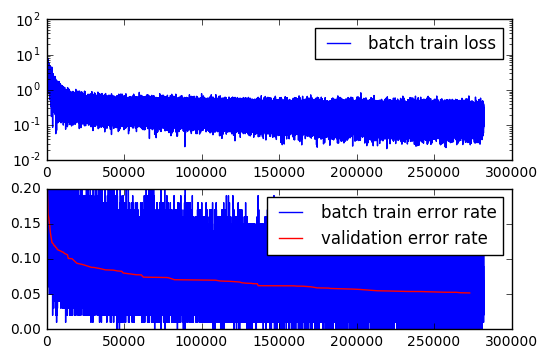

In [13]:
# pretty nice results:

#(momentum, reg, lr_initial, lr_schedule, err_rate) = report[sorted[1], :]
#(momentum, reg, lr_initial, lr_schedule) = (0.62399999969999997, 1e-08, 0.1, 2811706.625)
#(6.93333333e-01, 1.00000000e-08, 1.00000000e-01, 5.62341325e+06/2, 6.13000000e-02)
(momentum, reg, lr_initial, lr_schedule, err_rate) = [  9.90000000e-01,   2.15443469e-04,   1.33352143e-03, 3.16227766e+04 * 4,   1.48500000e-01]

net.reset()
SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum, reg, lr_initial, lr_schedule)
best_sofar = compute_error_rate(net, mnist_test_stream)

In [14]:
best_sofar

0.0588

In [ ]:
# fine tuning:

print("Errors: {0}".format(best_sofar))
space = np.array([0.9, 1.1])


getting_better = True
while getting_better:
    getting_better = False
    
    param_space = lr_initial * space
    err_rate = []
    for p in param_space:
        net.reset()
        SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum, reg, p, lr_schedule)
        err_rate.append(compute_error_rate(net, mnist_test_stream))
        print('.')
    best = np.array(err_rate).argmin()
    if err_rate[best] < best_sofar:
        best_sofar = err_rate[best]
        getting_better = True
        lr_initial = param_space[best]
    print("Errors: {0}".format(best_sofar))
    print("Params:", momentum, reg, lr_initial, lr_schedule)
    
    param_space = momentum * space
    err_rate = []
    for p in param_space:
        net.reset()
        SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, p, reg, lr_initial, lr_schedule)
        err_rate.append(compute_error_rate(net, mnist_test_stream))
        print('.')
    best = np.array(err_rate).argmin()
    if err_rate[best] < best_sofar:
        best_sofar = err_rate[best]
        getting_better = True
        momentum = param_space[best]
    print("Errors: {0}".format(best_sofar))
    print("Params:", momentum, reg, lr_initial, lr_schedule)
    
    param_space = reg * space
    err_rate = []
    for p in param_space:
        net.reset()
        SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum, p, lr_initial, lr_schedule)
        err_rate.append(compute_error_rate(net, mnist_test_stream))
        print('.')
    best = np.array(err_rate).argmin()
    if err_rate[best] < best_sofar:
        best_sofar = err_rate[best]
        getting_better = True
        reg = param_space[best]
    print("Errors: {0}".format(best_sofar))
    print("Params:", momentum, reg, lr_initial, lr_schedule)
    
    param_space = lr_schedule * space
    err_rate = []
    for p in param_space:
        net.reset()
        SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum, reg, lr_initial, p)
        err_rate.append(compute_error_rate(net, mnist_test_stream))
        print('.')
    best = np.array(err_rate).argmin()
    if err_rate[best] < best_sofar:
        best_sofar = err_rate[best]
        getting_better = True
        lr_schedule = param_space[best]
    print("Errors: {0}".format(best_sofar))
    print("Params:", momentum, reg, lr_initial, lr_schedule)

In [ ]:
net.reset()
SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum, reg, lr_initial, lr_schedule)

In [15]:
compute_error_rate(net, mnist_test_stream)

0.0588

# Problem 3 [2p bonus]

Implement norm constraints, i.e. limit the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

# Problem 4 [2p bonus]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout (the best
result is below 1\% for dropout!). Details: http://arxiv.org/pdf/1207.0580.pdf.

In [16]:
class AffineLayerWithDropout(AffineLayer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayerWithDropout, self).__init__(num_in, num_out, weight_init, bias_init, **kwargs)
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) +  self.b
        dropout = random.random_integers(0, 1, Y.shape)
        Y *= dropout
        return Y, fprop_context

In [17]:
training_net = FeedForwardNet([
        AffineLayerWithDropout(784,380),
        ReLULayer(),
        AffineLayerWithDropout(380,100),
        ReLULayer(),
        AffineLayerWithDropout(100,10),
        SoftMaxLayer()
        ])

At minibatch 100, batch loss 16.542854, batch error rate 83.000000%
At minibatch 200, batch loss 14.204600, batch error rate 80.000000%
At minibatch 300, batch loss 12.443492, batch error rate 78.000000%
At minibatch 400, batch loss 12.459587, batch error rate 76.000000%
At minibatch 500, batch loss 11.645951, batch error rate 78.000000%
After epoch 1: valid_err_rate: 0.799400% currently going to do 3 epochs
At minibatch 600, batch loss 13.132524, batch error rate 83.000000%
At minibatch 700, batch loss 10.637365, batch error rate 81.000000%
At minibatch 800, batch loss 13.028206, batch error rate 83.000000%
At minibatch 900, batch loss 10.565166, batch error rate 77.000000%
At minibatch 1000, batch loss 11.591715, batch error rate 79.000000%
After epoch 2: valid_err_rate: 0.801700% currently going to do 3 epochs
At minibatch 1100, batch loss 10.431383, batch error rate 77.000000%
At minibatch 1200, batch loss 11.594886, batch error rate 75.000000%
At minibatch 1300, batch loss 10.6155

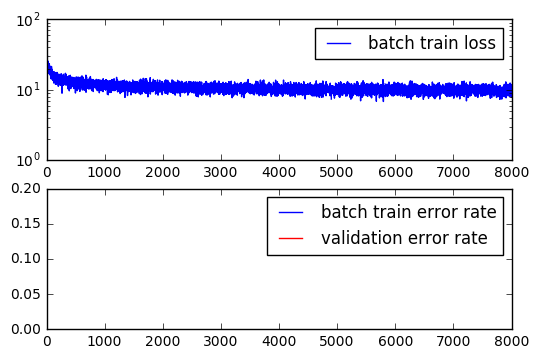

In [35]:
training_net.reset()
SGD(training_net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, momentum*0.8, reg, lr_initial*10, lr_schedule/10000)

In [30]:
test_net = FeedForwardNet([
        AffineLayer(784,380),
        ReLULayer(),
        AffineLayer(380,100),
        ReLULayer(),
        AffineLayer(100,10),
        SoftMaxLayer()
        ])
test_net.parameters = np.array(training_net.parameters) / 2.0

compute_error_rate(test_net, mnist_test_stream)

0.2969

# Problem 5 [3p bonus]

Implement convolutional and max-pooling layers and (without dropout) get a test error rate below 1.5%.

# Problem 6 [1-3p bonus]

Implement a data augmentation method (e.g. rotations, noise, crops) that will yield a significant test error rate reduction for your network. Number of bonus points depends on the ingenuity of your solution and error rate gains.